# SEMF Model

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares
from tabulate import tabulate

from dataclasses import dataclass, astuple, fields
from numbers import Number
from typing import Callable, Tuple
import numpy.typing as npt
import matplotlib.colorbar as mcb

## Create SEMF Function

In [2]:
# Create SEMF model function

NDArrayInt = npt.NDArray[np.int_]
NDArrayNumber = npt.NDArray[np.number]

@dataclass(order=True)
class Model:
    a_V: Number # Volume term
    a_S: Number # Surface term
    a_C: Number # Coulomb term
    a_A: Number # Asymmetry term
    a_P: Number # Base of parity term
    k_P: Number # Exponent of parity term


def E_B_per_nucleon(m: Model) -> Callable[[NDArrayInt, NDArrayInt], NDArrayNumber]:
    """
    SEMF model for binding energy per nucleon.

    """
    def SEMF(N: int, Z: int):
        if N <= 0 and Z <= 0:
            return np.nan

        A = N + Z
        sgn = 0 if A % 2 else (-1 if Z % 2 else 1)
        E_B = (
            m.a_V 
            - m.a_S / A**(1/3)  
            - m.a_C * Z * (Z-1) / A**(4/3)
            - m.a_A * (N-Z)**2 / A**2
            + m.a_P * sgn * A**(m.k_P-1)
        )       
        return E_B
    
    return np.vectorize(SEMF)


wapstra_model = Model(
    14.1,   # MeV 
    13,     # MeV
    0.595,  # MeV
    19,     # MeV
    33.5,   # MeV
    -0.75,
)
wapstra = E_B_per_nucleon(wapstra_model)
rohlf_model = Model(
    15.75,  # MeV
    17.8,   # MeV
    0.711,  # MeV
    23.7,   # MeV
    11.18,  # MeV
    -0.5,
)
rohlf = E_B_per_nucleon(rohlf_model)

In [3]:
# Create general plotting function for all the future plots

def create_plot(
    E_B: NDArrayNumber, 
    return_cbar: bool = False
) -> Tuple[plt.Figure, plt.Axes] | Tuple[plt.Figure, plt.Axes, mcb.Colorbar]:
    # Setup
    font = 15
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.tick_params(labelsize=font)

    # Plot
    im = ax.imshow(E_B, origin="lower", interpolation="none", zorder=5)
    ax.set_xlabel(r"Number of neutrons $N$", fontsize=font)
    ax.set_ylabel(r"Number of protons $Z$", fontsize=font)

    # Setup colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.35)
    cax.tick_params(labelsize=font)

    # Add colorbar
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label(r"Binding energy per nucleon $E_B$ (MeV)", fontsize=font)

    fig.tight_layout()

    if return_cbar:
        return fig, ax, cbar
    else:
        return fig, ax

In [4]:
N, Z = np.meshgrid(np.arange(0, 140), np.arange(0, 90))
E_B_rohlf = rohlf(N, Z)     # E_B is indexed by Z, N
E_B_rohlf[E_B_rohlf < 0] = 0

## Wapstra, A. H. (1958) Coefficients

In [5]:
N, Z = np.meshgrid(np.arange(0, 140), np.arange(1, 90))
E_B_wapstra = wapstra(N, Z)
E_B_wapstra[E_B_wapstra < 0] = 0

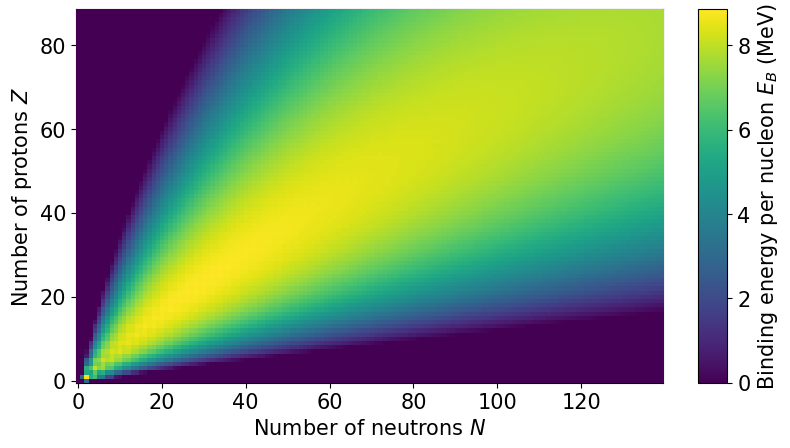

In [6]:
fig, ax = create_plot(E_B_wapstra)

## Experimental Data

In [7]:
df = pd.read_csv("../data/binding_energy_per_A.csv")
df["E"] = df["E"] / 1000  # Convert from keV to MeV
df["U(E)"] = df["U(E)"] / 1000  # Convert from keV to MeV
df

,N,Z,E,U(E),known,A,N-Z,N/Z
0,1,0,0.000000,0.000000e+00,1,1,1,inf
1,0,1,0.000000,0.000000e+00,1,1,-1,0.000000
2,1,1,1.112283,2.000000e-07,1,2,0,1.000000
3,2,1,2.827265,3.000000e-07,1,3,1,2.000000
4,1,2,2.572680,1.500000e-07,1,3,-1,0.500000
...,...,...,...,...,...,...,...,...
3553,176,117,7.095000,3.000000e-03,0,293,59,1.504274
3554,175,118,7.078000,2.000000e-03,0,293,57,1.483051
3555,177,117,7.092000,2.000000e-03,0,294,60,1.512821
3556,176,118,7.079000,2.000000e-03,0,294,58,1.491525


## Optimize Coefficients

In [8]:
# See https://github.com/yunruse/binding-energy for more details on this optimization
# cause I basically just did what they did here. Really, it's just a basic weighted
# least squares optimization with the weights shrinking to 0 as the number of nucleons
# decreases. 

A = df.N + df.Z
clamp = np.vectorize(lambda x: 0 if x < 0 else (1 if x > 1 else x), otypes=[np.float64])
Q = 5
weights = clamp((A - Q) / Q)

fit = least_squares(
    lambda params: weights * (df.E - E_B_per_nucleon(Model(*params))(df.N, df.Z)),
    astuple(rohlf_model),
    loss="soft_l1",
)

In [9]:
print("Rohlf: ", rohlf_model)
print("Fitted: ", Model(*fit.x))

Rohlf:  Model(a_V=15.75, a_S=17.8, a_C=0.711, a_A=23.7, a_P=11.18, k_P=-0.5)
Fitted:  Model(a_V=14.590978779570662, a_S=14.873742541554666, a_C=0.6290312108030797, a_A=19.067989764495994, a_P=9.481877950673008, k_P=-0.48142664374857497)


In [10]:
fit = least_squares(
    lambda params: weights * (df.E - E_B_per_nucleon(Model(*params))(df.N, df.Z)),
    astuple(wapstra_model),
    loss="soft_l1",
)

In [11]:
print("Wapstra: ", wapstra_model)
print("Fitted: ", Model(*fit.x))

Wapstra:  Model(a_V=14.1, a_S=13, a_C=0.595, a_A=19, a_P=33.5, k_P=-0.75)
Fitted:  Model(a_V=14.590978773855182, a_S=14.873742526301259, a_C=0.6290312103257254, a_A=19.067989752232084, a_P=9.481937430256412, k_P=-0.4814289172943598)


In [12]:
print(tabulate(list(zip([i.name for i in fields(Model(*fit.x))], astuple(Model(*fit.x)))), tablefmt="latex_raw"))

\begin{tabular}{lr}
\hline
 a_V & 14.591    \\
 a_S & 14.8737   \\
 a_C &  0.629031 \\
 a_A & 19.068    \\
 a_P &  9.48194  \\
 k_P & -0.481429 \\
\hline
\end{tabular}


## Plots

In [13]:
# Plot the optimized SEMF model
optimized_model = Model(*fit.x)
optimized = E_B_per_nucleon(optimized_model)

N, Z = np.meshgrid(np.arange(0, 140), np.arange(0, 90))
E_B_optimized = optimized(N, Z)
E_B_optimized[E_B_optimized < 0] = 0

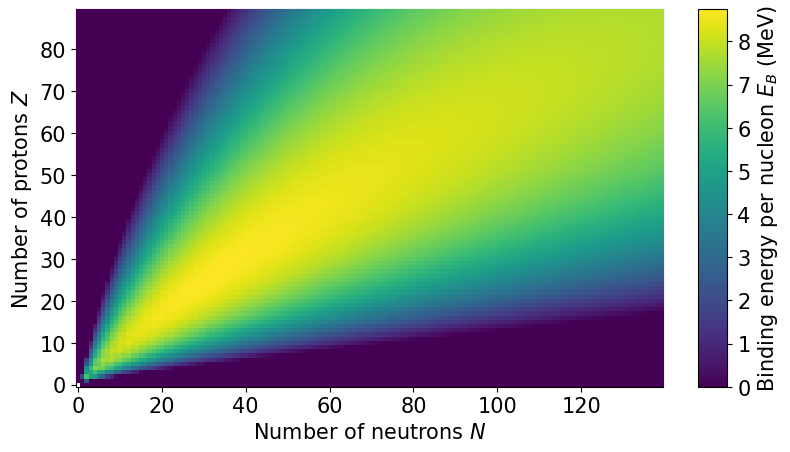

In [14]:
fig, ax = create_plot(E_B_optimized)

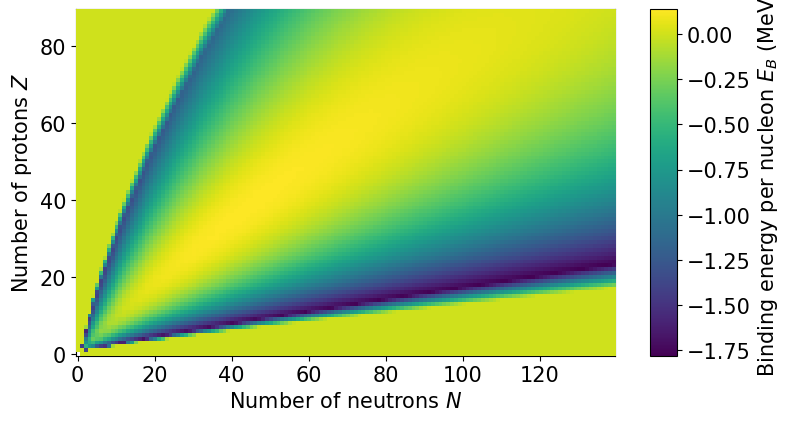

In [15]:
# Plot the different between the optimized and Rohlf's model
fig, ax = create_plot((E_B_rohlf - E_B_optimized))

In [16]:
df_dict = {(_.N, _.Z): _.E for _ in df.itertuples()}

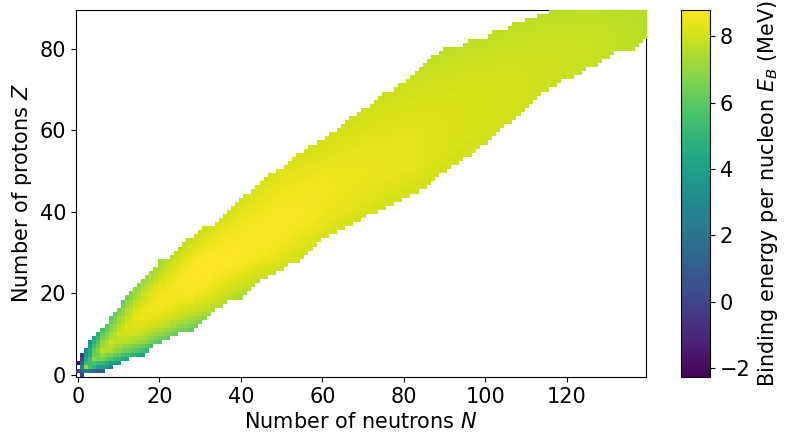

In [17]:
# Plot the experimental data
N, Z = np.meshgrid(np.arange(0, 140), np.arange(0, 90))
E_B_experimental = np.vectorize(lambda N, Z: df_dict.get((N, Z), np.nan))(N, Z)
fig, ax = create_plot(E_B_experimental)

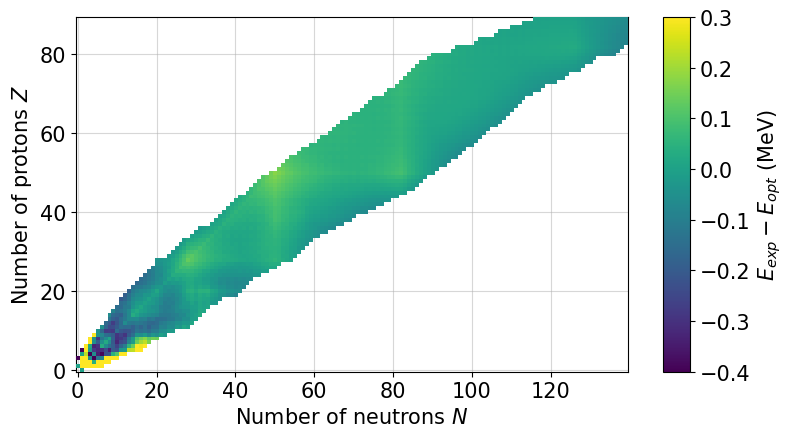

In [18]:
# Plot the difference between the experimental data and the optimized model.
# The colorbar is clipped to make the differences more visible.
tmp = E_B_experimental - E_B_optimized
tmp[tmp > 0.3] = 0.3
tmp[tmp < -0.4] = -0.4
fig, ax, cbar = create_plot(tmp, return_cbar=True)
ax.grid(alpha=0.5)
cbar.set_label(r"$E_{exp} - E_{opt}$ (MeV)", fontsize=15)

## Curves of Constant $A$ (Experimental)

Test out plotting curves of constant $A$ for various values of $A$. We can test out 
whether the correctly see parabolic curves and wobbles from the parity term.

Text(0.5, 1.0, 'Binding energy per nucleon for $A=200$')

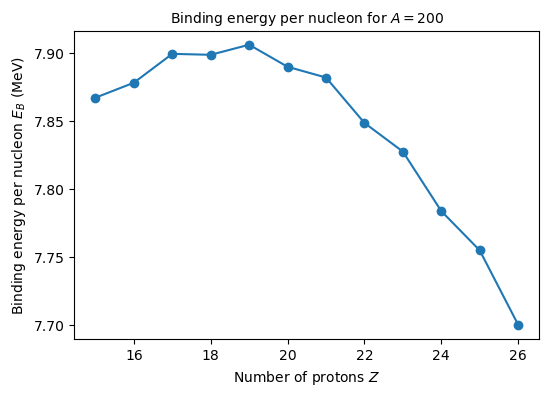

In [19]:
A = 200
E_curve = E_B_experimental[np.where(N + Z == A)][~np.isnan(E_B_experimental[np.where(N + Z == A)])]
Z_curve = np.flatnonzero(~np.isnan(E_B_experimental[np.where(N + Z == A)]))

fig, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(labelsize=10)
ax.plot(Z_curve, E_curve, "-o", label="Experimental")
ax.set_xlabel(r"Number of protons $Z$", fontsize=10)
ax.set_ylabel(r"Binding energy per nucleon $E_B$ (MeV)", fontsize=10)
ax.set_title(f"Binding energy per nucleon for $A={A}$", fontsize=10)

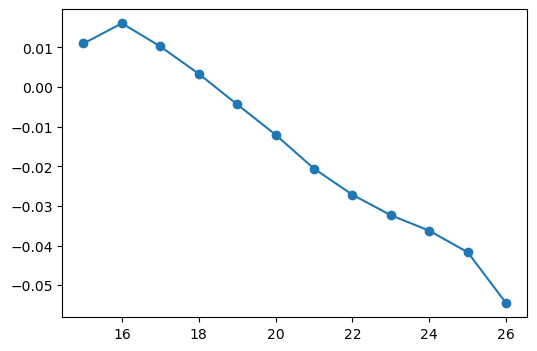

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(labelsize=10)
ax.plot(Z_curve, np.gradient(E_curve), "-o", label="Gradient", zorder=0)

## Curves of Constant $A$

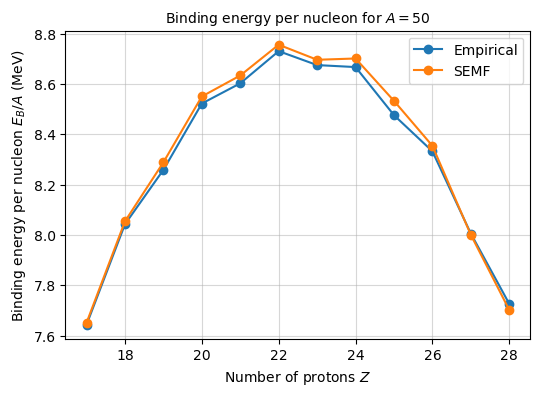

In [21]:
# Attempt 1: E vs Z, constant A
A = 50

# Only get SEMF values where E_B_experimental is not NaN
# Don't forget E is indexed by Z, N
E_curve_semf = E_B_optimized[np.where(N + Z == A)][~np.isnan(E_B_experimental[np.where(N + Z == A)])]
Z_curve_semf = np.flatnonzero(~np.isnan(E_B_experimental[np.where(N + Z == A)]))

E_curve = E_B_experimental[np.where(N + Z == A)][~np.isnan(E_B_experimental[np.where(N + Z == A)])]
Z_curve = np.flatnonzero(~np.isnan(E_B_experimental[np.where(N + Z == A)]))

fig, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(labelsize=10)
ax.plot(Z_curve_semf, E_curve_semf, "-o", label="Empirical")
ax.plot(Z_curve, E_curve, "-o", label="SEMF")
# ax.vlines([A // 2], E_curve.min(), E_curve.max(), linestyles="dashed", label="A // 2")

ax.set_xlabel(r"Number of protons $Z$", fontsize=10)
ax.set_ylabel(r"Binding energy per nucleon $E_B/A$ (MeV)", fontsize=10)
ax.set_title(f"Binding energy per nucleon for $A={A}$", fontsize=10)
ax.legend()
ax.grid(alpha=0.5)

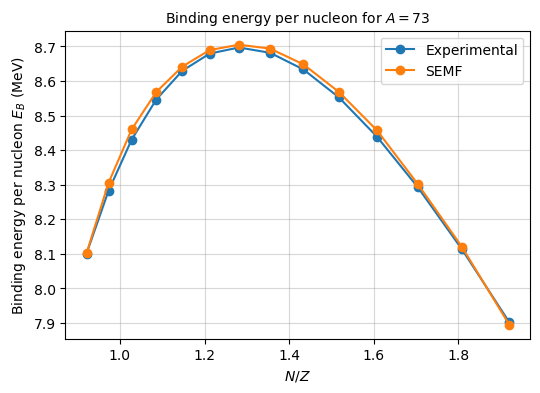

In [22]:
# Attempt 2: E vs Z-N, constant A
A = 73

# Only get SEMF values where E_B_experimental is not NaN
# Don't forget E is indexed by Z, N
E_curve_semf = E_B_optimized[np.where(N + Z == A)][~np.isnan(E_B_experimental[np.where(N + Z == A)])]
E_curve = E_B_experimental[np.where(N + Z == A)][~np.isnan(E_B_experimental[np.where(N + Z == A)])]

Z_curve = np.flatnonzero(~np.isnan(E_B_experimental[np.where(N + Z == A)]))
N_curve = A - Z_curve

fig, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(labelsize=10)
ax.plot(N_curve / Z_curve, E_curve_semf, "-o", label="Experimental")
ax.plot(N_curve / Z_curve, E_curve, "-o", label="SEMF")

ax.set_xlabel(r"$N/Z$", fontsize=10)
ax.set_ylabel(r"Binding energy per nucleon $E_B$ (MeV)", fontsize=10)
ax.set_title(f"Binding energy per nucleon for $A={A}$", fontsize=10)
ax.legend()
ax.grid(alpha=0.5)

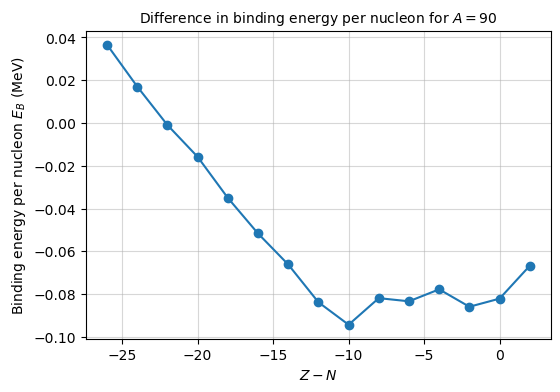

In [23]:
# Attempt 3: E_SEMF-E_exp vs Z-N, constant A
A = 90

# Only get SEMF values where E_B_experimental is not NaN
# Don't forget E is indexed by Z, N
E_curve_semf = E_B_optimized[np.where(N + Z == A)][~np.isnan(E_B_experimental[np.where(N + Z == A)])]
E_curve = E_B_experimental[np.where(N + Z == A)][~np.isnan(E_B_experimental[np.where(N + Z == A)])]

Z_curve = np.flatnonzero(~np.isnan(E_B_experimental[np.where(N + Z == A)]))
N_curve = A - Z_curve

fig, ax = plt.subplots(figsize=(6, 4))
ax.tick_params(labelsize=10)
ax.plot(Z_curve - N_curve, E_curve_semf - E_curve, "-o")

ax.set_xlabel(r"$Z - N$", fontsize=10)
ax.set_ylabel(r"Binding energy per nucleon $E_B$ (MeV)", fontsize=10)
ax.set_title(f"Difference in binding energy per nucleon for $A={A}$", fontsize=10)
ax.grid(alpha=0.5)

## Heatmap of binding energy on top of A vs N-Z

In [24]:
A_2, NminusZ = np.meshgrid(np.arange(0, 200), np.arange(-30, 90))
df_dict2 = {(_.A, _._7): _.E for _ in df.itertuples()}

# Indexed by NminusZ, A
E_B_experimental_2 = np.vectorize(lambda A, Z: df_dict2.get((A, Z), np.nan))(A_2, NminusZ)

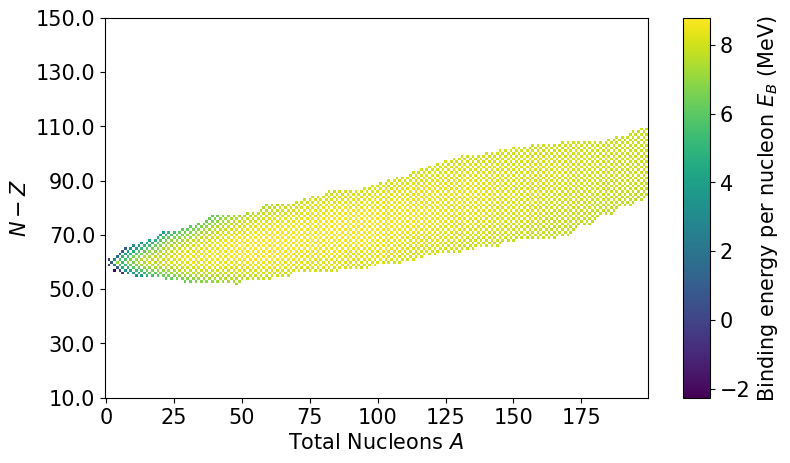

In [25]:
# Setup
font = 15
fig, ax = plt.subplots(figsize=(8, 10))
ax.tick_params(labelsize=font)

# Plot
im = ax.imshow(E_B_experimental_2, origin="lower", interpolation="none")
ax.set_xlabel(r"Total Nucleons $A$", fontsize=font)
ax.set_ylabel(r"$N - Z$", fontsize=font)
ax.set_yticks(ax.get_yticks(), ax.get_yticks() - NminusZ.min())

# Setup colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.35)
cax.tick_params(labelsize=font)

# Add colorbar
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"Binding energy per nucleon $E_B$ (MeV)", fontsize=font)

fig.tight_layout()

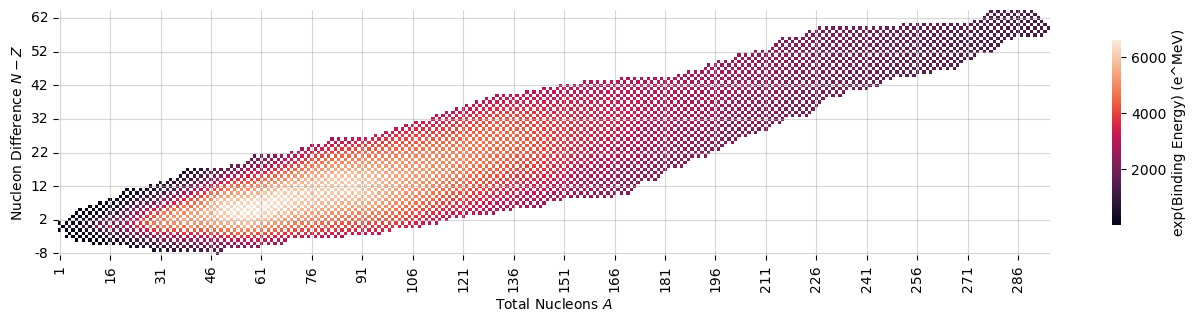

In [26]:
fig, ax = plt.subplots(figsize=(16, 8))
new_df = df.pivot(index="N-Z", columns="A", values="E")
sns.heatmap(np.exp(new_df), ax=ax, square=True, cbar_kws={"shrink": 0.3, "label": "exp(Binding Energy) (e^MeV)"})
ax.invert_yaxis()
ax.set_yticks(ax.get_yticks()[::5])
ax.set_xticks(ax.get_xticks()[::3])
ax.set_xlabel(r"Total Nucleons $A$")
ax.set_ylabel(r"Nucleon Difference $N - Z$")
ax.grid(alpha=0.5)
plt.show()

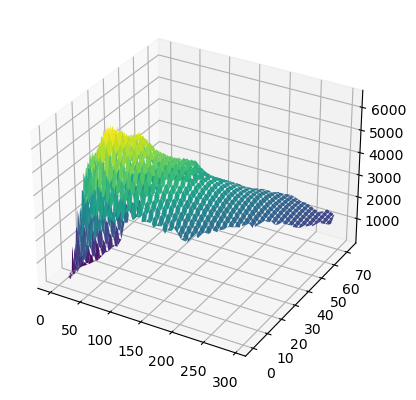

In [27]:
# Prepare 3d axes
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
xpos, ypos = np.meshgrid(np.arange(new_df.shape[1]), np.arange(new_df.shape[0]))

# Plot 
ax.plot_surface(xpos, ypos, np.exp(new_df.values), cmap='viridis', linewidth=0)
plt.show()


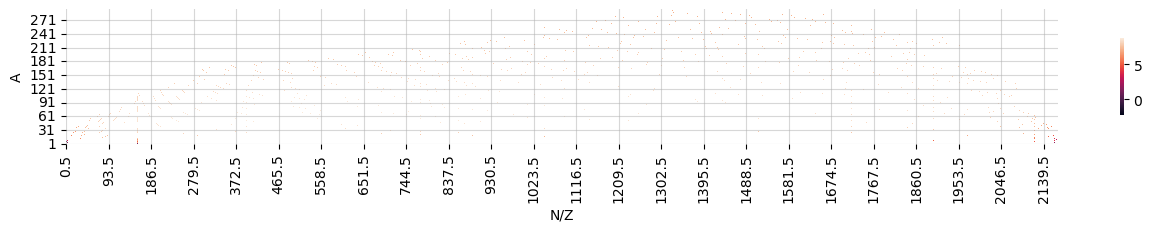

In [28]:
fig, ax = plt.subplots(figsize=(16, 10))
new_df = df.pivot(index="A", columns="N/Z", values="E")
sns.heatmap(new_df, ax=ax, square=True, cbar_kws={"shrink": 0.1})

# Only plot every other y tick
ax.set_yticks(ax.get_yticks()[::5])
ax.set_xticks(ax.get_xticks()[::3])

# Set x tick label to only have 2 decimal places
ax.set_xticklabels([f"{_:.1f}" for _ in ax.get_xticks()])
ax.invert_yaxis()

ax.grid(alpha=0.5)